In [4]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col, to_date, coalesce, lit, mode, when, count, max
import pandas as pd
from datetime import datetime, timedelta
from utils.session import get_cached_session, get_session
import utils.get_data as gd
from datetime import date, timedelta

2025-09-08 10:39:49.575 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [3]:
session = get_session()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/e7c6f609-f63a-4ec7-b71e-6734c4c9d231/saml2?SAMLRequest=nZNNc9owEIb%2Fikc9%2BxOCQQNkHJgUTxNKMWk73IS8BhVbIloZk%2Fz6ChNm0kNy6M0jP7t6vO96eHuqSucIGoWSIxJ6AXFAcpULuR2Rp9W92ycOGiZzVioJI%2FICSG7HQ2RVeaBJbXZyCc81oHFsI4m0fTEitZZUMRRIJasAqeE0Sx4faOQF9KCVUVyV5F3J5xUMEbSxhteSHIXV2xlzoL7fNI3XdDylt34UBIEfDHxLnZEvV%2F5kv%2BkDPvSD7pm3hMUXb253Ql5G8JnW5gIhna1WC3fxPVsRJ7mqTpTEugKdgT4KDk%2FLh4sAWoNskSxXyXyeZDMPGBq3Rjfy2GutwUOpmqJke%2BCqOtTG9vfsk19A7pdqK%2BwI0umIHPYi%2FxHjXXbcbczp6%2B9Zam%2BdrNfb%2FU7zX%2F0nHTd%2Fnl%2FBfHucNixLOXF%2BXjOOzhmniDWk8pyssUdBdOMGAzfor8Iu7QxoJ%2FTim8GaOFObrJDMtJVX%2FdbDqwTXClVhlCyFhNYSYt4rerZT0eswtws8djdxCG4v7nR5lw%2FyqBP657wjctkh2oro8f9PZui%2F7%2FO2mHObVTpdqFLwF%2Bde6YqZj6MMvbA9EblbtCiFiokyyXMNiDbSslTN

In [40]:
zone_map_df = gd.get_price_strategies()
price_zones_dict = dict(zip(zone_map_df['ZONENAME'], zone_map_df['ZONECODE']))

moving_zone_key = 2
target_zone_key = 1

moving_zone_label = price_zones_dict.get(moving_zone_key)
target_zone_label = price_zones_dict.get(target_zone_key)

vendor_df = session.table('edl.phq.vendor_master').select(
    col('v_id').alias('vm_v_id'),
    col('vendor'),
    col('vendor_name')
)

im_df = session.table('edl.phq.item_master').select(
    col('item_id').alias('im_item_id'),
    col('upc_ean')
)

item_df = session.table('sbx_biz.marketing.t_item').select(
    col('"Product UPC"').alias('product_upc'),
    col('"Unit Size"').alias('unit_size'),
    col('"Item Description"').alias('item_description'),
    col('"Brand"').alias('brand'),
    col('"Group ID"').alias('group_id'),
    col('"Category ID"').alias('category_id'),
    col('"Anchor Group ID"').alias('anchor_group_id')
)

eff_date = to_date(lit('2025-09-06'), 'YYYY-MM-DD')

moving_reg_item_prices_df = gd.get_reg_item_prices(eff_date, moving_zone_key)
target_reg_item_prices_df = gd.get_reg_item_prices(eff_date, target_zone_key)

moving_promo_item_prices_df = gd.get_promo_item_prices(eff_date, moving_zone_key)
target_promo_item_prices_df = gd.get_promo_item_prices(eff_date, target_zone_key)

moving_mvmt_df = gd.get_26w_movement(eff_date, moving_zone_key)
target_mvmt_df = gd.get_26w_movement(eff_date, target_zone_key)

diff_reg_item_prices_df = moving_reg_item_prices_df.join(
    target_reg_item_prices_df,
    on = 
        (moving_reg_item_prices_df['item_id'] == target_reg_item_prices_df['item_id']) &
        (moving_reg_item_prices_df['v_id'] == target_reg_item_prices_df['v_id']),
    how = 'fullouter'
    ).filter(
        (moving_reg_item_prices_df['unit_price'].is_null()) |
        (target_reg_item_prices_df['unit_price'].is_null()) |
        (moving_reg_item_prices_df['unit_price'] != target_reg_item_prices_df['unit_price'])
    ).select(
        moving_reg_item_prices_df['item_id'].alias('moving_item_id'),
        moving_reg_item_prices_df['v_id'].alias('moving_v_id'),
        moving_reg_item_prices_df['zonename'].alias('moving_zone'),
        moving_reg_item_prices_df['price_strategy'].alias('moving_price_strategy'),
        moving_reg_item_prices_df['start_date'].alias('moving_start'),
        moving_reg_item_prices_df['end_date'].alias('moving_end'),
        moving_reg_item_prices_df['price_multiple'].alias('moving_multiple'),
        moving_reg_item_prices_df['unit_price'].alias('moving_retail'),
        target_reg_item_prices_df['item_id'].alias('target_item_id'),
        target_reg_item_prices_df['v_id'].alias('target_v_id'),
        target_reg_item_prices_df['price_strategy'].alias('target_price_strategy'),
        target_reg_item_prices_df['zonename'].alias('target_zone'),
        target_reg_item_prices_df['start_date'].alias('target_start'),
        target_reg_item_prices_df['end_date'].alias('target_end'),
        target_reg_item_prices_df['price_multiple'].alias('target_multiple'),
        target_reg_item_prices_df['unit_price'].alias('target_retail')
    )

df = diff_reg_item_prices_df.join(
    moving_promo_item_prices_df,
    on = 
        (diff_reg_item_prices_df['moving_item_id'] == moving_promo_item_prices_df['item_id']) &
        (diff_reg_item_prices_df['moving_v_id'] == moving_promo_item_prices_df['v_id']),
    how = 'left'
).join(
    target_promo_item_prices_df,
    on = 
        (diff_reg_item_prices_df['target_item_id'] == target_promo_item_prices_df['item_id']) &
        (diff_reg_item_prices_df['target_v_id'] == target_promo_item_prices_df['v_id']),
    how = 'left'
).join(
    moving_mvmt_df,
    on =
        (diff_reg_item_prices_df['moving_price_strategy'] == moving_mvmt_df['zonecode']) &
        (diff_reg_item_prices_df['moving_item_id'] == moving_mvmt_df['sales_item_id']),
    how = 'left'
).join(
    target_mvmt_df,
    on =
        (diff_reg_item_prices_df['moving_price_strategy'] == target_mvmt_df['zonecode']) &
        (diff_reg_item_prices_df['target_item_id'] == target_mvmt_df['sales_item_id']),
    how = 'left'
).join(
    vendor_df,
    coalesce(
        diff_reg_item_prices_df['moving_v_id'],
        diff_reg_item_prices_df['target_v_id']
     ) == vendor_df['vm_v_id'],
    how = 'left'
).join(
    im_df,
    coalesce(
        diff_reg_item_prices_df['moving_item_id'],
         diff_reg_item_prices_df['target_item_id']
     ) == im_df['im_item_id'],
    how = 'left'
).join(
    item_df,
    im_df['upc_ean'] == item_df['product_upc'],
    how = 'left'
).select(
    im_df['im_item_id'],
    item_df['product_upc'].alias('UPC'),
    item_df['item_description'].alias('Item Description'),
    item_df['unit_size'].alias('Unit Size'),
    item_df['anchor_group_id'].alias('Anchor Group ID'),
    item_df['brand'].alias('"Brand"'),
    item_df['group_id'].alias('Group ID'),
    item_df['category_id'].alias('Category ID'),
    vendor_df['vendor'].alias('Vendor Number'),
    vendor_df['vendor_name'].alias('"Vendor"'),
    when(
        diff_reg_item_prices_df['moving_item_id'].is_null(),
        'Add to Moving'
    ).when(
        diff_reg_item_prices_df['target_item_id'].is_null(),
        'Add to Target'
    ).when(
        moving_mvmt_df['26w_mvmt'].is_null(),
        'Change Moving ASAP'
    ).when(
        moving_mvmt_df['26w_mvmt'].is_not_null(),
        'Change Current Slow'
    ).otherwise(
        'Audit'
    ).alias('"Action"'),
    when(
        diff_reg_item_prices_df['moving_retail'] < diff_reg_item_prices_df['target_retail'],
        'up'
    ).when(
        diff_reg_item_prices_df['moving_retail'] > diff_reg_item_prices_df['target_retail'],
        'down'
    ).alias('Price Movement'),
    when(
        diff_reg_item_prices_df['moving_retail'].is_not_null() &
        diff_reg_item_prices_df['target_retail'].is_not_null(),
        diff_reg_item_prices_df['target_retail'] - diff_reg_item_prices_df['moving_retail']
    ).alias('Price Variance'),
        when(
        diff_reg_item_prices_df['moving_retail'].is_not_null() &
        diff_reg_item_prices_df['target_retail'].is_not_null(),
        (diff_reg_item_prices_df['target_retail'] - diff_reg_item_prices_df['moving_retail']) /
        diff_reg_item_prices_df['moving_retail']
    ).alias('Price Variance %'),
    lit(moving_zone_label).alias('Moving Zone'),
    to_date(diff_reg_item_prices_df['moving_start']).alias('M From'),
    to_date(diff_reg_item_prices_df['moving_end']).alias('M Through'),
    diff_reg_item_prices_df['moving_multiple'].alias('M Multiple'),
    diff_reg_item_prices_df['moving_retail'].alias('M Retail'),
    moving_mvmt_df['26w_mvmt'].alias('M 26w Mvmt'),
    lit(target_zone_label).alias('Target Zone'),
    to_date(diff_reg_item_prices_df['target_start']).alias('T From'),
    to_date(diff_reg_item_prices_df['target_end']).alias('T Through'),
    diff_reg_item_prices_df['target_multiple'].alias('T Multiple'),
    diff_reg_item_prices_df['target_retail'].alias('T Retail'),
    target_mvmt_df['26w_mvmt'].alias('T 26w Mvmt'),
    moving_promo_item_prices_df['description'].alias('M Promo'),
    to_date(moving_promo_item_prices_df['start_date']).alias('M Promo From'),
    to_date(moving_promo_item_prices_df['end_date']).alias('M Promo Through'),
    moving_promo_item_prices_df['price_multiple'].alias('M Promo Multiple'),
    moving_promo_item_prices_df['unit_price'].alias('M Promo Retail'),
    target_promo_item_prices_df['description'].alias('T Promo'),
    to_date(target_promo_item_prices_df['start_date']).alias('T Promo From'),
    to_date(target_promo_item_prices_df['end_date']).alias('T Promo Through'),
    target_promo_item_prices_df['price_multiple'].alias('T Promo Multiple'),
    target_promo_item_prices_df['unit_price'].alias('T Promo Retail')
)

In [41]:
df = df.to_pandas()

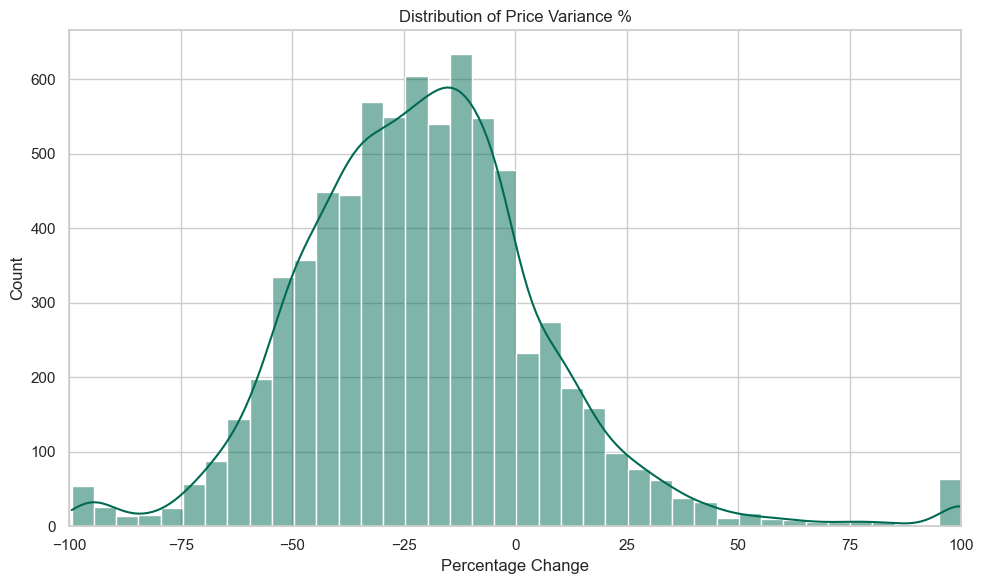

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
percentages = df['Price Variance %'].dropna() * 100

# Clip values to stay within -100% to 100%
percentages = percentages.clip(-100, 100)

sn_hex = '#006a52'

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(percentages, bins=40, kde=True, color=sn_hex)
plt.title('Distribution of Price Variance %')
plt.xlabel('Percentage Change')
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()



In [25]:
pd.set_option('display.max_columns', None)

# Optional: show all rows too
pd.set_option('display.max_rows', None)

# Optional: show full content in each column
pd.set_option('display.max_colwidth', None)


In [35]:
temp_df = df[df['Price Variance %'] < -0.99]
temp_df

,IM_ITEM_ID,UPC,Item Description,Unit Size,Anchor Group ID,Brand,Group ID,Category ID,Vendor Number,Vendor,Action,Price Movement,Price Variance,Price Variance %,Moving Zone,M From,M Through,M Multiple,M Retail,M 26w Mvmt,Target Zone,T From,T Through,T Multiple,T Retail,T 26w Mvmt,M Promo,M Promo From,M Promo Through,M Promo Multiple,M Promo Retail,T Promo,T Promo From,T Promo Through,T Promo Multiple,T Promo Retail
1924,18019,00021818034223,24 X 1.75/2.0 TUBE,1.000 CT,0002181803422,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-596.50,-0.994183,None,2014-06-28,None,1.0,599.99,NaN,None,2000-07-28,None,1.0,3.49,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN
6551,35751,00038728420213,MAGNETIZER DEMAGNTZR,1.000 CT,0003872842021,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-352.20,-0.992141,None,2013-04-20,None,1.0,354.99,NaN,None,1999-03-30,None,1.0,2.79,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN
7188,18171,00021995445843,FLICKER,1.000 CT,0002199544584,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-198.70,-0.993550,None,2015-01-18,None,1.0,199.99,NaN,None,2004-03-11,None,1.0,1.29,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN
11902,44155,00044038029770,BULB C7 FLICKER,1.000 CT,0004403802977,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-198.50,-0.992550,None,2015-01-18,None,1.0,199.99,NaN,None,2005-05-05,None,1.0,1.49,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN
14098,35228,00038561311099,1X10' PVC SCH40,1.000 FT,0003856131109,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-4.55,-0.991285,None,2017-09-16,None,1.0,4.59,NaN,None,2005-07-25,None,1.0,0.04,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN
14647,68330,00074196002575,GARRITY,1.000 CT,0007419600257,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-894.50,-0.993900,None,2017-10-14,None,1.0,899.99,NaN,None,2005-07-25,None,1.0,5.49,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN
15660,49179,00049821688004,5X7 STEP FLASHING,1.000 CT,0004982168800,None,873.0,3065.0,00003841,DO IT BEST CORP,Change Moving ASAP,down,-24.86,-0.994798,None,2014-11-22,None,1.0,24.99,NaN,None,2004-11-08,None,1.0,0.13,NaN,None,None,None,NaN,NaN,None,None,None,NaN,NaN


In [173]:
ip_df = session.table('edl.phq.item_price').filter(
    (col('ip_start_date') <= default_date) &
    (coalesce(to_date(col('IP_END_DATE')), lit('9999-12-31')) >= default_date)
).select(
    col('item_id').alias('ip_item_id'),
    col('item_price_id').alias('item_price_id'),
    col('v_id').alias('v_id'),
    col('ip_unit_price').alias('ip_unit_price'),
    col('ip_price_multiple').alias('ip_price_multiple'),
    col('ip_start_date').alias('ip_start_date'),
    col('ip_end_date').alias('ip_end_date'),
    col('store_id').alias('ip_store_nbr'),
    col('pt_type').alias('ip_pt_type')
)

im_df = session.table('edl.phq.item_master').select(
    col('item_id').alias('im_item_id'),
    col('upc_ean').alias('upc_ean')
)

item_df = session.table('edw.rtl.retail_item_vw').select(
    col('product_upc').alias('product_upc'),
    col('mdse_grp_key').alias('mdse_grp_key'),
    col('mdse_catgy_key').alias('mdse_catgy_key'),
    col('item_description').alias('item_description')
)

zg_df = session.table('edl.phq.sn_rev_zonegrp').filter(
    (col('zonegroupcode') == 1) &
    (col('zonecode') == 1)
).select(
    col('zonecode').alias('zonecode'),
    col('zonename').alias('zonename'),
    col('storecode').alias('zg_store_nbr')
)

pt_df = session.table('edl.phq.price_type').select(
    col('pt_type').alias('pt_pt_type'),
    col('description').alias('pt_description')
)

df = ip_df.join(
    zg_df,
    zg_df['zg_store_nbr'] == ip_df['ip_store_nbr'],
    how = 'inner'
).join(
    pt_df,
    ip_df['ip_pt_type'] == pt_df['pt_pt_type'],
    how = 'inner'
)

df = df.group_by(
    col('ip_item_id'),
    col('v_id'),
    col('zonecode')
    ).agg(
    mode(when(col('ip_pt_type') == 1, col('ip_unit_price'))).alias('unit_price'),
    mode(when(col('ip_pt_type') == 1, col('ip_price_multiple'))).alias('price_multiple'),
    mode(when(col('ip_pt_type') == 1, col('ip_start_date'))).alias('start_date'),
    mode(when(col('ip_pt_type') == 1, col('ip_end_date'))).alias('end_date'),
    count(when(col('ip_pt_type') == 1, lit(1))).alias('store_count'),

    mode(when(col('ip_pt_type') != 1, col('pt_description'))).alias('promo_type'),
    mode(when(col('ip_pt_type') != 1, col('ip_unit_price'))).alias('promo_unit_price'),
    mode(when(col('ip_pt_type') != 1, col('ip_price_multiple'))).alias('promo_price_multiple'),
    mode(when(col('ip_pt_type') != 1, col('ip_start_date'))).alias('promo_start_date'),
    mode(when(col('ip_pt_type') != 1, col('ip_end_date'))).alias('promo_end_date'),
    count(when(col('ip_pt_type') != 1, lit(1))).alias('promo_store_count')
    )


In [174]:
df = df.to_pandas()


In [177]:
zg_df.to_pandas()

,ZONECODE,ZONENAME,ZG_STORE_NBR
0,1,SB AND ELKHART,2304
1,1,SB AND ELKHART,2306
2,1,SB AND ELKHART,2310
3,1,SB AND ELKHART,2311
4,1,SB AND ELKHART,2312
5,1,SB AND ELKHART,2314
6,1,SB AND ELKHART,2315
7,1,SB AND ELKHART,2316
8,1,SB AND ELKHART,2317
9,1,SB AND ELKHART,2324


In [117]:
len(df)

7374294

In [74]:
def prefix_columns(df, prefix):
    for col_name in df.columns:
        df = df.with_column_renamed(col_name, f"{prefix}_{col_name}")
    return df

ip_df = session.table('edl.phq.item_price')
irpd_df = session.table('edl.phq.item_retail_price_dt')
im_df = session.table('edl.phq.item_master')
pt_df = session.table('edl.phq.price_type')
zg_df = session.table('edl.phq.sn_rev_zonegrp')
item_df = session.table('edw.rtl.retail_item_vw')

ip_df = prefix_columns(ip_df, 'ip')
irpd_df = prefix_columns(irpd_df, 'irpd')
im_df = prefix_columns(im_df, 'im')
pt_df = prefix_columns(pt_df, 'pt')
zg_df = prefix_columns(zg_df, 'zg')
item_df = prefix_columns(item_df, 'item')

#joins
df = irpd_df.join(
    ip_df,
    irpd_df['irpd_item_price_id'] == ip_df['ip_item_price_id'],
    how = 'inner'
).join(
    im_df,
    ip_df['ip_item_id'] == im_df['im_item_id'],
    how = 'inner'
).join(
    item_df,
    im_df['im_upc_ean'] == item_df['item_product_upc'],
    how = 'inner'
).join(
    pt_df,
    irpd_df['irpd_pt_type'] == pt_df['pt_pt_type'],
    how = 'inner'
).join(
    zg_df,
    irpd_df['irpd_store_id'] == zg_df['zg_storecode']
)

#filters
c_df = df.filter(
    (irpd_df['irpd_ip_start_date'] <= default_date) &
    (irpd_df['irpd_ip_end_date'] >= default_date) &
    #(pt_df['pt_pt_type'] == '1') &
    (ip_df['ip_price_strategy'] != 0) &
    (zg_df['zg_zonecode'] == 1) &
    (zg_df['zg_zonegroupcode'] == 1)
).select(
    zg_df['zg_zonename'],
    item_df['item_product_upc'],
    irpd_df['irpd_v_id'],
    pt_df['pt_description'],
    irpd_df['irpd_ip_unit_price'],
    irpd_df['irpd_ip_price_multiple'],
    irpd_df['irpd_ip_start_date'],
    irpd_df['irpd_ip_end_date']
)
t_df = df.filter(
    (irpd_df['irpd_ip_start_date'] <= default_date) &
    (irpd_df['irpd_ip_end_date'] >= default_date) &
    #(pt_df['pt_pt_type'] == '1') &
    (ip_df['ip_price_strategy'] != 0) &
    (zg_df['zg_zonecode'] == 1) &
    (zg_df['zg_zonegroupcode'] == 1)
).select(
    zg_df['zg_zonename'],
    item_df['item_product_upc'],
    irpd_df['irpd_v_id'],
    pt_df['pt_description'],
    irpd_df['irpd_ip_unit_price'],
    irpd_df['irpd_ip_price_multiple'],
    irpd_df['irpd_ip_start_date'],
    irpd_df['irpd_ip_end_date']
)

#aggregations
result_df = df.group_by(
    zg_df['zg_zonename'],
    item_df['item_product_upc'],
    irpd_df['irpd_v_id']
).agg(
    mode(when(pt_df['pt_description'] == 'Regular', irpd_df['irpd_ip_unit_price'])).alias('IP_UNIT_PRICE'),
    mode(when(pt_df['pt_description'] == 'Regular', irpd_df['irpd_ip_price_multiple'])).alias('IP_PRICE_MULTIPLE'),
    mode(when(pt_df['pt_description'] == 'Regular', irpd_df['irpd_ip_start_date'])).alias('IP_START_DATE'),
    mode(when(pt_df['pt_description'] == 'Regular', irpd_df['irpd_ip_end_date'])).alias('IP_END_DATE'),
    count(when(pt_df['pt_description'] == 'Regular', lit(1))).alias('STORE_COUNT'),

    mode(when(pt_df['pt_description'] != 'Regular', pt_df['pt_description'])).alias('PROMO_TYPE'),
    mode(when(pt_df['pt_description'] != 'Regular', irpd_df['irpd_ip_unit_price'])).alias('PROMO_UNIT_PRICE'),
    mode(when(pt_df['pt_description'] != 'Regular', irpd_df['irpd_ip_price_multiple'])).alias('PROMO_PRICE_MULTIPLE'),
    mode(when(pt_df['pt_description'] != 'Regular', irpd_df['irpd_ip_start_date'])).alias('PROMO_START_DATE'),
    mode(when(pt_df['pt_description'] != 'Regular', irpd_df['irpd_ip_end_date'])).alias('PROMO_END_DATE'),
    count(when(pt_df['pt_description'] != 'Regular', lit(1))).alias('PROMO_STORE_COUNT')
)


In [ ]:
ip_df = session.table('edl.phq.item_price').select(
    col('item_id'),
    col('item_price_id'),
    col('v_id'),
    col('ip_unit_price'),
    col('price_strategy')
)
irpd_df = session.table('edl.phq.item_retail_price_dt')

ip_df = ip_df.join(
    irpd_df,
    on = ip_df['item_price_id'] == irpd_df['item_price_id'],
    how = 'inner'
).filter(
    (irpd_df['ip_start_date'] <= default_date) &
    (irpd_df['ip_end_date'] >= default_date) &
    (ip_df['price_strategy'] != 0)
).select(
    ip_df['item_id'],
    ip_df['item_price_id'],
    irpd_df['v_id'].alias('irpd_v_id'),
    ip_df['v_id'].alias('ip_v_id'),
    ip_df['ip_unit_price'],
    irpd_df['ip_unit_price']
).filter(irpd_df['v_id'] != ip_df['v_id']).to_pandas()


In [73]:
ip_df

,l_0254_ITEM_ID,l_0254_ITEM_PRICE_ID,IRPD_V_ID,IP_V_ID,l_0254_IP_UNIT_PRICE,r_0255_IP_UNIT_PRICE
0,2251652,251057622,651,51,2.69,2.69
1,2251652,251057622,123,51,2.69,2.69
2,2251652,251057622,175,51,2.69,2.69
3,2251652,251057623,123,51,2.69,2.69
4,2251652,251057623,175,51,2.69,2.69


In [ ]:
df = irpd_df.join(
    ip_df,
    irpd_df['item_price_id'] == ip_df['item_price_id'],
    how = 'inner'
).join(
    im_df,
    ip_df['item_id'] == im_df['item_id'],
    how = 'inner'
).join(
    item_df,
    im_df['upc_ean'] == item_df['product_upc_13_cd'],
    how = 'inner'
)

df.show(100)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
df

In [11]:
today = date.today()
days_since_saturday = (today.weekday() - 5) % 7
default_date = today - timedelta(days=days_since_saturday)
default_date

datetime.date(2025, 8, 23)

In [2]:
session = get_cached_session()

2025-08-27 17:22:35.542 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 17:22:36.048 
  command:

    streamlit run c:\Users\212739\OneDrive - SpartanNash\Documents\Data\Streamlit\Pricing App\.venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-27 17:22:36.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 17:22:36.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 17:22:36.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 17:22:36.557 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 17:22:36.563 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare 

In [20]:
df = session.table("SBX_BIZ.MARKETING.T_ITEM").select(
        col('"Anchor Group ID"'),
        col('"Item Description"'),
        col('"Product UPC"'),
        col('"Unit Size"'),
        col('"Group ID"'),
        col('"Category ID"'),
        col('"Brand"')
    ).to_pandas()

In [15]:
item_prices_df = session.table('EDL.PHQ.ITEM_PRICE').filter(
    (default_date >= to_date(col('IP_START_DATE'))) & 
        (default_date <= coalesce(to_date(col('IP_END_DATE')), lit('9999-12-31'))) &
    (col('PRICE_STRATEGY') == 11) & 
    (col('RECORD_STATUS') != 3)
)

item_prices_df.show(10)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
item_prices_df = session.table('EDL.PHQ.ITEM_PRICE').filter(
    (col('PRICE_STRATEGY') == 11) & 
    (col('RECORD_STATUS') != 3)
)

item_prices_df.show(10)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------